LDA を使った言語の綴りと発音のクラスタリング

黒田 航 (Kuroda, Kow) [kow.kuroda@gmail.com]

Revisions

2024/07/02
1) gen_ngrams.py を使って，skippy n-gram を一般の n について生成可能にした 2) boundary symbol # の追加処理を追加

In [371]:
## imports
import sys, os, glob, re, random
import unicodedata
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [372]:
## 処理設定
verbose = False
## 言語の選別
select_languages = True
## 言語の割合の均等化
balanced = True
## 色分けで言語名の変わりに語族を使う
color_lang_family = True
## 英語をゲルマン語に含める
germanic_includes_english = False

### LDA 用
## トピック数: 値が大きくなるほど，分離が悪くなる
n_topics = 10 # 30は多過ぎる？

### DTM 構築
## term の最低頻度
term_min_freq = 5
## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
## term filtering の効果は顕著なので，色々と試した方が良い
term_abuse_threshold = 0.003

## doc の長さの上限
max_doc_size  = 13
print(f"max_doc_size: {max_doc_size}")
## doc の長さの下限
min_doc_size  = 5
print(f"min_doc_size: {min_doc_size}")
## doc に境界記号を加えるかどうか
add_boundary_symbols = False
print(f"add_boundary_symbol: {add_boundary_symbols}")

## doc の設定
doc_type         = 'form'  # 変更不可
doc_attrs        = [ 'spell', 'sound' ]
doc_attr         = doc_attrs[1]
print(f"doc_attr: {doc_attr}")

## term の設定
term_size     = 'character' # 出力用の名目変数
term_types    = [ '1gram', '2gram', '3gram', '4gram',
                 'skippy2gram', 'skippy3gram', 'skippy4gram' ]
term_type     = term_types[-2]
print(f"term_type: {term_type}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

## skippy n-gram の表記
gap_mark = "…"

## skippy n-gram の結合範囲
max_gap_size = round(max_doc_size * 0.75)
print(f"max_gap_size: {max_gap_size}")

max_doc_size: 13
min_doc_size: 5
add_boundary_symbol: False
doc_attr: sound
term_type: skippy3gram
max_gap_size: 10


# 言語の選別

In [373]:
## 言語の選別

##綴り解析で使える言語
## arabic, bengali, chinese, esperanto, english, finnish, french, german, greek, hebrew, hungarian,
## icelandic, irish, italian, japanese, russian, spanish, swahili, turkish

##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

import re
spell_set0     = "arabic, bengali, chinese, esperato, english, finnish, french, german, greek, \
    hebrew, hungarian, icelandic, irish, italian, japanese, korean, russian, spanish, swahili, turkish"
spell_set1     = "arabic, hebrew, english, esperanto, finnish, french, german, greek, hungarian, \
    icelandic, irish, russian, italian, spanish, swahili, turkish"
spell_set2     = "english, esperanto, french, finnish, german, hungarian, icelandic, irish, \
    spanish, italian, swahili, turkish"
spell_set3     = "english, esperanto, finnish, german, hungarian, swahili, turkish"
spell_romance  = "esperanto, french, italian, spanish"
spell_germanic = "english, german, icelandic, irish"
spell_esoteric = "finnish, hungarian, irish, swahili, turkish"
spell_asian    = "bengali, chinese, japanese, korean"
#
sound_set0 = "arabic, chinese, english, esperato, french, german, icelandic, japanese, korean, \
    spanish, swahili"
sound_set1 = "arabic, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili"
##
if doc_attr == "spell":
    selected_langs = re.split(r",\s*", spell_set1)
elif doc_attr == 'sound':
    selected_langs = re.split(r",\s*", sound_set1)
    
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 10 languages:
['arabic', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']


In [374]:
## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Light24

In [375]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
wd = Path(".")
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
#
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [376]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_name_list = "arabic, bengali, chinese, english, esperanto, \
    finnish, french, greek, german, hebrew, hungarian, \
    icelandic, irish, italian, japanese, korean, russian, spanish, swahili, turkish"

langs = re.split(r",\s*", lang_name_list)
lang_settings = { lang : 0 for lang in langs }
print(f"{len(lang_settings.keys())} langs are available")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
20 langs are available
{'arabic': 0, 'bengali': 0, 'chinese': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'greek': 0, 'german': 0, 'hebrew': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'japanese': 0, 'korean': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'bengali': 0, 'chinese': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'greek': 0, 'german': 0, 'hebrew': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'japanese': 0, 'korean': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0}


In [377]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                ## single out the entry
                dfx['form'] = dfx['form'].apply(lambda x: re.split(r",\s+", x)[0])
                ## normalize characters
                dfx['form'] = dfx['form'].apply(lambda x: unicodedata.normalize('NFC', x))
                ## add boundary symbols
                if add_boundary_symbols:
                    dfx['form'] = dfx['form'].apply(lambda x: f"#{x}#")
                ##
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'bengali', 'chinese', 'english', 'esperanto', 'finnish', 'french', 'greek', 'german', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'japanese', 'korean', 'russian', 'spanish', 'swahili', 'turkish']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Bengali-r0-1m-mc.csv
reading: data-words/base-sound-Chinese-main-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Chinese-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-spell-Finnish-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-spell-

In [378]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,hungarian,icelandic,irish,italian,japanese,korean,russian,spanish,swahili,turkish
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
995,çoğul,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,öfke,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,iddia,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [379]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df.random(30)

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,icelandic,irish,italian,japanese,korean,russian,spanish,swahili,turkish,language
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,turkish
995,çoğul,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,turkish
996,öfke,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,turkish
997,iddia,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,turkish


In [380]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'german', 'icelandic', 'irish' ]
else:
    germanic_langs = [ 'german', 'icelandic', 'irish' ]
# roman
romance_langs    = [ 'esperanto', 'french', 'italian', 'spanish' ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,irish,italian,japanese,korean,russian,spanish,swahili,turkish,language,family
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,turkish,turkish
995,çoğul,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,turkish,turkish
996,öfke,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,turkish,turkish
997,iddia,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,turkish,turkish


In [381]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,italian,japanese,korean,russian,spanish,swahili,turkish,language,family,size
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,turkish,turkish,5
995,çoğul,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,turkish,turkish,5
996,öfke,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,turkish,turkish,4
997,iddia,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,turkish,turkish,5


In [382]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: sound


,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,italian,japanese,korean,russian,spanish,swahili,turkish,language,family,size
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,3
879,wiᵑgi,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,5
880,hasiɾa,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,6
881,maɗai,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,5


In [383]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,italian,japanese,korean,russian,spanish,swahili,turkish,language,family,size
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,3
879,wiᵑgi,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,5
880,hasiɾa,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,6
881,maɗai,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,5


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_96640/696675105.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



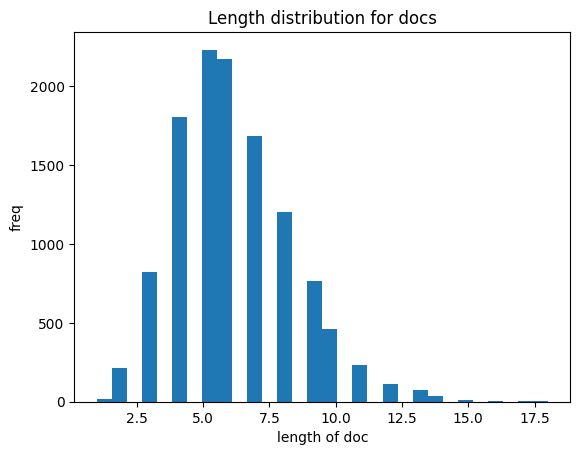

In [384]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

データを長さで濾過

In [385]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 13
54 cases removed due to max_doc_size
min doc size: 5
2864 cases removed due to min_doc_size
2918 cases removed in total


In [386]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort =  True))

spell
0    8946
Name: count, dtype: int64
sound
1    8946
Name: count, dtype: int64


In [387]:
## 結果の検査 2
for lang in langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    8278
1     668
Name: count, dtype: int64
bengali
0    8946
Name: count, dtype: int64
chinese
0    8946
Name: count, dtype: int64
english
0    6014
1    2932
Name: count, dtype: int64
esperanto
0    8384
1     562
Name: count, dtype: int64
finnish
0    8946
Name: count, dtype: int64
french
0    8068
1     878
Name: count, dtype: int64
greek
0    8946
Name: count, dtype: int64
german
0    8406
1     540
Name: count, dtype: int64
hebrew
0    8946
Name: count, dtype: int64
hungarian
0    8946
Name: count, dtype: int64
icelandic
0    8192
1     754
Name: count, dtype: int64
irish
0    8946
Name: count, dtype: int64
italian
0    8946
Name: count, dtype: int64
japanese
0    8343
1     603
Name: count, dtype: int64
korean
0    8333
1     613
Name: count, dtype: int64
russian
0    8946
Name: count, dtype: int64
spanish
0    8202
1     744
Name: count, dtype: int64
swahili
0    8294
1     652
Name: count, dtype: int64
turkish
0    8946
Name: count, dtype: int64


英語事例の割合補正

In [388]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    eng_df = raw_df[raw_df['english'] == 1]
    non_eng_df = raw_df[raw_df['english'] == 0]
    eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
    raw_df = pd.concat([eng_reduced_df, non_eng_df])
#
raw_df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,italian,japanese,korean,russian,spanish,swahili,turkish,language,family,size
1347,kɑntɹæst,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,8
81,æbsəlutlɪ,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,9
3199,əbaʊt,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,5
3779,θaʊzənd,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,7
2220,pɹɪvɛnt,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,kuaⁿɗaa,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,7
877,tʃuᵐvi,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,6
879,wiᵑgi,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,5
880,hasiɾa,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,swahili,swahili,6


In [389]:
## 結果の検査 3
for lang in langs:
    print(raw_df[lang].value_counts().sort_index())

arabic
0    5932
1     668
Name: count, dtype: int64
bengali
0    6600
Name: count, dtype: int64
chinese
0    6600
Name: count, dtype: int64
english
0    6014
1     586
Name: count, dtype: int64
esperanto
0    6038
1     562
Name: count, dtype: int64
finnish
0    6600
Name: count, dtype: int64
french
0    5722
1     878
Name: count, dtype: int64
greek
0    6600
Name: count, dtype: int64
german
0    6060
1     540
Name: count, dtype: int64
hebrew
0    6600
Name: count, dtype: int64
hungarian
0    6600
Name: count, dtype: int64
icelandic
0    5846
1     754
Name: count, dtype: int64
irish
0    6600
Name: count, dtype: int64
italian
0    6600
Name: count, dtype: int64
japanese
0    5997
1     603
Name: count, dtype: int64
korean
0    5987
1     613
Name: count, dtype: int64
russian
0    6600
Name: count, dtype: int64
spanish
0    5856
1     744
Name: count, dtype: int64
swahili
0    5948
1     652
Name: count, dtype: int64
turkish
0    6600
Name: count, dtype: int64


# 解析

In [390]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [391]:
## ngram の追加
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

bases = df[doc_type]

In [392]:
## 1gram 列の追加
unigrams = ngrams.list_gen_unigrams(bases, sep = r"", check = False)
unigrams = [ [ u for u in L if len(u) > 0 ] for L in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,japanese,korean,russian,spanish,swahili,turkish,language,family,size,1gram
913,bendeɾ,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,spanish,romance,6,"[b, e, n, d, e, ɾ]"
134,moβimjento,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,spanish,romance,10,"[m, o, β, i, m, j, e, n, t, o]"
47,auskulti,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,esperanto,romance,8,"[a, u, s, k, u, l, t, i]"
133,antes,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,spanish,romance,5,"[a, n, t, e, s]"
317,na̠ɭɕ͈i,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,korean,korean,7,"[n, a, ̠, ɭ, ɕ, ͈, i]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,upaⁿɗe,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,swahili,swahili,6,"[u, p, a, ⁿ, ɗ, e]"
108,duono,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,esperanto,romance,5,"[d, u, o, n, o]"
322,ʃaɛnen,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,german,germanic,6,"[ʃ, a, ɛ, n, e, n]"
505,aːlqism,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,arabic,arabic,7,"[a, ː, l, q, i, s, m]"


In [393]:
## 1gram 列の追加
unigrams = ngrams.list_gen_unigrams(bases, sep = r"", check = False)
unigrams = [ [ u for u in L if len(u) > 0 ] for L in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
df

,form,freq,spell,sound,arabic,bengali,chinese,english,esperanto,finnish,...,japanese,korean,russian,spanish,swahili,turkish,language,family,size,1gram
913,bendeɾ,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,spanish,romance,6,"[b, e, n, d, e, ɾ]"
134,moβimjento,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,spanish,romance,10,"[m, o, β, i, m, j, e, n, t, o]"
47,auskulti,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,esperanto,romance,8,"[a, u, s, k, u, l, t, i]"
133,antes,1.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,spanish,romance,5,"[a, n, t, e, s]"
317,na̠ɭɕ͈i,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,korean,korean,7,"[n, a, ̠, ɭ, ɕ, ͈, i]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,upaⁿɗe,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,swahili,swahili,6,"[u, p, a, ⁿ, ɗ, e]"
108,duono,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,esperanto,romance,5,"[d, u, o, n, o]"
322,ʃaɛnen,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,german,germanic,6,"[ʃ, a, ɛ, n, e, n]"
505,aːlqism,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,arabic,arabic,7,"[a, ː, l, q, i, s, m]"


In [394]:
## 2gram 列の追加
bigrams = ngrams.list_gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
if verbose:
    print(random.sample(bigrams, 3))

In [395]:
df['2gram'] = bigrams
df['2gram']

913               [be, en, nd, de, eɾ, b, e, n, d, e, ɾ]
134    [mo, oβ, βi, im, mj, je, en, nt, to, m, o, β, ...
47     [au, us, sk, ku, ul, lt, ti, a, u, s, k, u, l,...
133                      [an, nt, te, es, a, n, t, e, s]
317        [na, a̠, ̠ɭ, ɭɕ, ɕ͈, ͈i, n, a, ̠, ɭ, ɕ, ͈, i]
                             ...                        
179               [up, pa, aⁿ, ⁿɗ, ɗe, u, p, a, ⁿ, ɗ, e]
108                      [du, uo, on, no, d, u, o, n, o]
322               [ʃa, aɛ, ɛn, ne, en, ʃ, a, ɛ, n, e, n]
505        [aː, ːl, lq, qi, is, sm, a, ː, l, q, i, s, m]
317               [vɪ, ɪn, nt, tʏ, ʏr, v, ɪ, n, t, ʏ, r]
Name: 2gram, Length: 6600, dtype: object

In [396]:
## 3gram列の追加
trigrams = ngrams.list_gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]
#
if verbose:
    print(random.sample(trigrams, 3))

In [397]:
df['3gram'] = trigrams
df['3gram']

913    [ben, end, nde, deɾ, be, en, nd, de, eɾ, b, e,...
134    [moβ, oβi, βim, imj, mje, jen, ent, nto, mo, o...
47     [aus, usk, sku, kul, ult, lti, au, us, sk, ku,...
133       [ant, nte, tes, an, nt, te, es, a, n, t, e, s]
317    [na̠, a̠ɭ, ̠ɭɕ, ɭɕ͈, ɕ͈i, na, a̠, ̠ɭ, ɭɕ, ɕ͈, ...
                             ...                        
179    [upa, paⁿ, aⁿɗ, ⁿɗe, up, pa, aⁿ, ⁿɗ, ɗe, u, p,...
108       [duo, uon, ono, du, uo, on, no, d, u, o, n, o]
322    [ʃaɛ, aɛn, ɛne, nen, ʃa, aɛ, ɛn, ne, en, ʃ, a,...
505    [aːl, ːlq, lqi, qis, ism, aː, ːl, lq, qi, is, ...
317    [vɪn, ɪnt, ntʏ, tʏr, vɪ, ɪn, nt, tʏ, ʏr, v, ɪ,...
Name: 3gram, Length: 6600, dtype: object

In [398]:
## skippy 2grams の生成
#import ngrams_skippy
#skippy_2grams = [ ngrams_skippy.gen_skippy2grams(x,
#             missing_mark = gap_mark, max_distance = max_distance_val, check = False)
#             for x in df['1gram'] ]
## The code above is replace by the following generalized one.
import gen_ngrams
skippy_2grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 3, sep = '', missing_mark = gap_mark,
                                                    max_distance = max_gap_size, check = False) for x in df['1gram'] ]
## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [399]:
## skippy 2gram 列の追加
df['skippy2gram'] = skippy_2grams
df['skippy2gram']

913    [ben, be…d, be…e, be…ɾ, b…nd, b…n…e, b…n…ɾ, b…...
134    [moβ, mo…i, mo…m, mo…j, mo…e, mo…n, mo…t, mo…o...
47     [aus, au…k, au…u, au…l, au…t, au…i, a…sk, a…s…...
133    [ant, an…e, an…s, a…te, a…t…s, a…es, nte, nt…s...
317    [na̠, na…ɭ, na…ɕ, na…͈, na…i, n…̠ɭ, n…̠…ɕ, n…̠...
                             ...                        
179    [upa, up…ⁿ, up…ɗ, up…e, u…aⁿ, u…a…ɗ, u…a…e, u…...
108    [duo, du…n, du…o, d…on, d…o…o, d…no, uon, uo…o...
322    [ʃaɛ, ʃa…n, ʃa…e, ʃa…n, ʃ…ɛn, ʃ…ɛ…e, ʃ…ɛ…n, ʃ…...
505    [aːl, aː…q, aː…i, aː…s, aː…m, a…lq, a…l…i, a…l...
317    [vɪn, vɪ…t, vɪ…ʏ, vɪ…r, v…nt, v…n…ʏ, v…n…r, v…...
Name: skippy2gram, Length: 6600, dtype: object

In [400]:
## skippy 3grams の生成
import gen_ngrams
skippy_3grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 3, sep = '',
                                                 missing_mark = gap_mark, max_distance = max_gap_size, check = False) for x in df['1gram'] ]
## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [401]:
## skippy 3gram 列の追加
df['skippy3gram'] = skippy_3grams
df['skippy3gram']

913    [ben, be…d, be…e, be…ɾ, b…nd, b…n…e, b…n…ɾ, b…...
134    [moβ, mo…i, mo…m, mo…j, mo…e, mo…n, mo…t, mo…o...
47     [aus, au…k, au…u, au…l, au…t, au…i, a…sk, a…s…...
133    [ant, an…e, an…s, a…te, a…t…s, a…es, nte, nt…s...
317    [na̠, na…ɭ, na…ɕ, na…͈, na…i, n…̠ɭ, n…̠…ɕ, n…̠...
                             ...                        
179    [upa, up…ⁿ, up…ɗ, up…e, u…aⁿ, u…a…ɗ, u…a…e, u…...
108    [duo, du…n, du…o, d…on, d…o…o, d…no, uon, uo…o...
322    [ʃaɛ, ʃa…n, ʃa…e, ʃa…n, ʃ…ɛn, ʃ…ɛ…e, ʃ…ɛ…n, ʃ…...
505    [aːl, aː…q, aː…i, aː…s, aː…m, a…lq, a…l…i, a…l...
317    [vɪn, vɪ…t, vɪ…ʏ, vɪ…r, v…nt, v…n…ʏ, v…n…r, v…...
Name: skippy3gram, Length: 6600, dtype: object

In [402]:
## skippy 4grams の生成
import gen_ngrams
skippy_4grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 4, sep = '',
                                                 missing_mark = gap_mark, max_distance = max_gap_size, check = False) for x in df['1gram'] ]
## 包括的 skippy 4-grams の生成
if ngram_is_inclusive:
    for i, q2 in enumerate(skippy_4grams):
        q2.extend(skippy_3grams[i])
#
if verbose:
    random.sample(skippy_4grams, 3)

In [403]:
## skippy 4gram 列の追加
df['skippy4gram'] = skippy_4grams
df['skippy4gram']

913    [bend, ben…e, ben…ɾ, be…de, be…d…ɾ, be…eɾ, b…n...
134    [moβi, moβ…m, moβ…j, moβ…e, moβ…n, moβ…t, moβ…...
47     [ausk, aus…u, aus…l, aus…t, aus…i, au…ku, au…k...
133    [ante, ant…s, an…es, a…tes, ntes, ntes, ant, a...
317    [na̠ɭ, na̠…ɕ, na̠…͈, na̠…i, na…ɭɕ, na…ɭ…͈, na…...
                             ...                        
179    [upaⁿ, upa…ɗ, upa…e, up…ⁿɗ, up…ⁿ…e, up…ɗe, u…a...
108    [duon, duo…o, du…no, d…ono, uono, uono, duo, d...
322    [ʃaɛn, ʃaɛ…e, ʃaɛ…n, ʃa…ne, ʃa…n…n, ʃa…en, ʃ…ɛ...
505    [aːlq, aːl…i, aːl…s, aːl…m, aː…qi, aː…q…s, aː…...
317    [vɪnt, vɪn…ʏ, vɪn…r, vɪ…tʏ, vɪ…t…r, vɪ…ʏr, v…n...
Name: skippy4gram, Length: 6600, dtype: object

DTM 構築

In [404]:
## LDA 構築の基になる document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
bots = df[term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<82769 unique tokens: ['b', 'ben', 'be…d', 'be…e', 'be…ɾ']...>


In [405]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 5
abuse filter: 0.003
Dictionary<13318 unique tokens: ['ben', 'be…e', 'be…ɾ', 'b…de', 'b…nd']...>


In [406]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 6600


LDA モデルの構築

In [407]:
## LDA モデルの構築
from gensim.models import LdaModel
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 10
LdaModel<num_terms=82769, num_topics=10, decay=0.5, chunksize=2000>


In [408]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10
0,a,a,əʁ…̃,t,jɔ̃,a,a,o,a,a
1,tʏr,t,ə…ɔ̃,a,əʁɛ,t,ama,e,a…a…a,ənt
2,ʃən,i,a,i,zəʁ,ntɪ,aː…a,nto,jʌ̹,ʰa̠
3,ː…ʏr,s,ʁɔ̃,ijj,i…əʁ,̃…ɑ̃,a…aː,en…o,ʌ̹n,d͡ʑ
4,ɪ…ən,e,e,ːto,i,n,ʑa̠,ent,t…a…a,a̠…i
5,k,k,ent,i…aː,a…jɔ,e,͡…a̠,t,l,a̠ŋ
6,ɪʃə,aɾi,əʁɔ,t͡…o,əʁa,s,a…l…a,əʁj,ma…a,i
7,ɪʃ…n,t…ʁa,e…to,aːt,s…ɔ̃,ɑ̃s,l…ma,e…to,ala,sʰ…̠
8,t,taɾ,t,n,i…ɔ̃,r,d͡…a,s,i,ʰ…̠ŋ
9,eɪʃ,a…a…i,i,o,ʁ…ɔ̃,i…ɑ̃,͡ʑa,i,a̠…̚,s…a̠


LDAvis の実行

In [409]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
use_MMDS  = True
use_tSNE  = False
if use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [410]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [411]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[1.         1.         0.99999994 1.         1.         1.
 1.         1.         1.0000001  1.        ]


In [412]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

10.000001


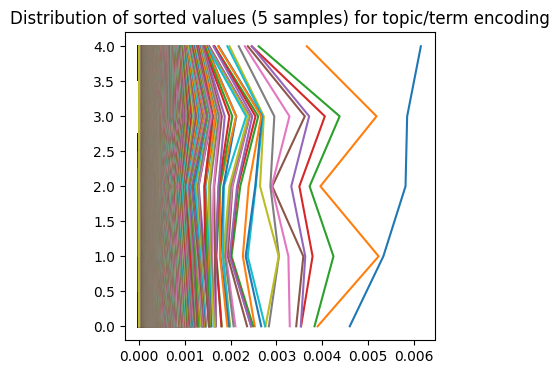

In [413]:
## term エンコード値の分布を確認
import matplotlib.pyplot as plt
plt.figure(figsize = (4,4))
sampling_rate = 0.5
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [414]:
## tSNE を使った topics のグループ化 (3D)
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [415]:
## Plotlyを使って tSNE の結果の可視化 (3D)

import plotly.graph_objects as go

top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"3D tSNE view for LDA (#topics: {n_topics}, doc: {doc_attr}, term: {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [416]:
## 構築した LDA モデルを使って文(書)を分類する

## パラメター
ntopics = n_topics # LDA の構築の最に指定した値を使う
check    = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

6600

In [417]:
## enc 列の追加

df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

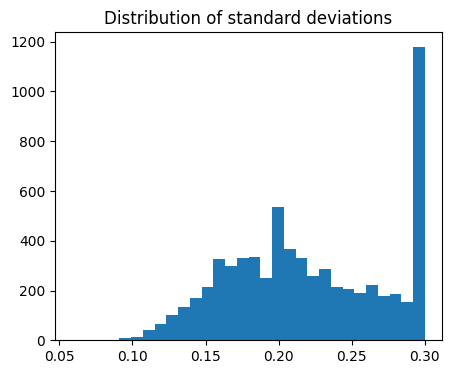

In [418]:
## エンコーディングのstd の分布を見る

import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (5,4))
plt.hist([ np.std(x) for x in df['enc'] ], bins = 30)

plt.title("Distribution of standard deviations")
plt.show()

doc エンコード

In [419]:
## 一様分布の事例を除外
import numpy as np

print(f"{len(df)} instances before filtering")

check = False
doc_enc = df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

6600 instances before filtering
std 1st min: 0.05896572023630142
std 2nd min: 0.2999783456325531


In [420]:
## df_filtered の定義

import numpy as np

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"Filtering leaves {len(df_filtered)} instances: ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.07499458640813828
Filtering leaves 6599 instances: (1 instances removed)


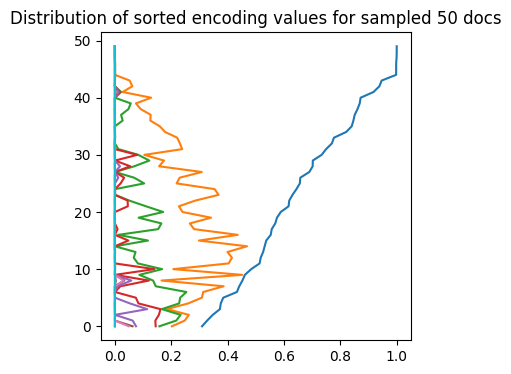

In [421]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])

plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [422]:
len(df_filtered['language'])

6599

In [423]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic       668
english      586
esperanto    561
french       878
german       540
icelandic    754
japanese     603
korean       613
spanish      744
swahili      652
Name: count, dtype: int64

tSNE 用の事例サンプリング

In [424]:
## tSNE 用の事例サンプリング = tSNE_df の定義
tSNE_sampling = True
tSNE_sampling_rate = 0.33
if tSNE_sampling:
    tSNE_df_original = df_filtered.copy()
    sample_n = round(len(tSNE_df_original) * tSNE_sampling_rate)
    tSNE_df = tSNE_df_original.sample(sample_n)
    print(f"tSNE_df has {len(tSNE_df)} rows after sampling")
else:
    tSNE_df = df_filtered

tSNE_df has 2178 rows after sampling


In [425]:
tSNE_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'bengali', 'chinese',
       'english', 'esperanto', 'finnish', 'french', 'greek', 'german',
       'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'japanese',
       'korean', 'russian', 'spanish', 'swahili', 'turkish', 'language',
       'family', 'size', '1gram', '2gram', '3gram', 'skippy2gram',
       'skippy3gram', 'skippy4gram', 'enc'],
      dtype='object')

In [426]:
tSNE_df['language'].value_counts(sort = True).sort_index()

language
arabic       228
english      179
esperanto    186
french       291
german       188
icelandic    231
japanese     195
korean       215
spanish      246
swahili      219
Name: count, dtype: int64

In [427]:
tSNE_df['family'].value_counts(sort = True).sort_index()

family
arabic      228
english     179
germanic    419
japanese    195
korean      215
romance     723
swahili     219
Name: count, dtype: int64

tSNE 結果の可視化 (Plotly を使った)

In [428]:
## tSNE の結果の可視化: Plotly を使った 3D 描画
import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
perplexity_max_val = round(len(tSNE_df)/4)
print(f"perplexity_max_val: {perplexity_max_val}")
#perplexity_increment = 120
divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
early_exit = False
for step, perplexity_val in enumerate(range(divider, perplexity_max_val, perplexity_increment)):
    if early_exit:
        if step > 0:
            continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)
    ## データに適用
    doc_enc = np.array(list(tSNE_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)
    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    ## 変数指定
    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            tSNE_df[colored_var]) # zip(..)が必要
    df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(df[colored_var]):
        part = df[df[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 4),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ##　題名の指定
    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of '{doc_attr}'s via LDA ({n_topics} topics, {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 544
perplexity_increment: 109


/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [429]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



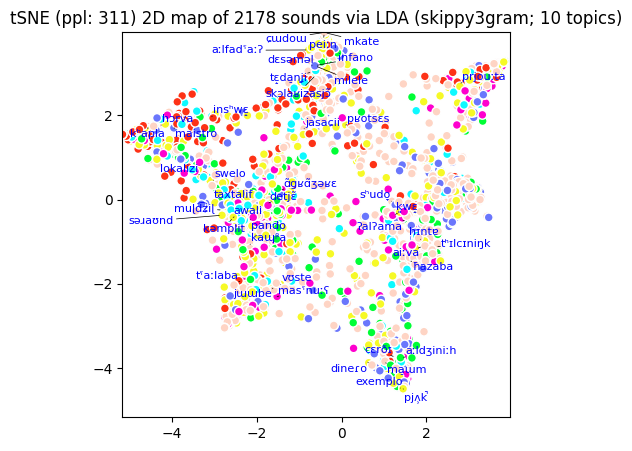

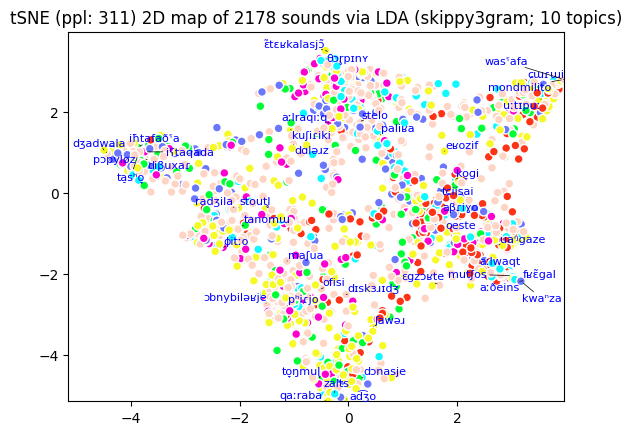

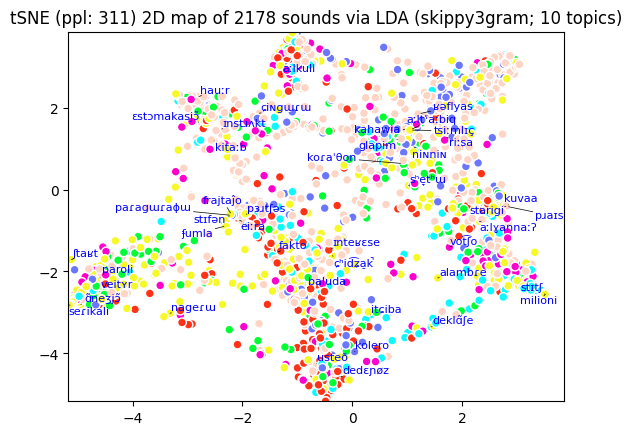

In [430]:
## tSNE の結果の可視化 (2D)
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"

## tSNE 事例の生成
partition_factor = 7
perplexity_selected = round(len(tSNE_df)/partition_factor)
tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(tSNE_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'
#
S = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], tSNE_df[colored_var]) # zip(..)が必要
df = pd.DataFrame(S, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
#
check = False
for roll in [ np.roll([0,1,2], -i) for i in range(0,3) ]:
    if check:
        print(roll)
    X, Y = df.iloc[:, roll[0]], df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(tSNE_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    lab_sampling_rate = 0.02
    lab_sample_n = round(len(tSNE_df) * lab_sampling_rate)
    sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(tSNE_df[doc_type]), lab_sample_n) ]

    ## labels の生成
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 8, color = 'blue'))
    ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
                #force_points = 0.2,
                ## Commnent out the following line if you get AttributeError: FancyArrowPatch.set() got an unexpected keyword argument 'expand_points'
                #force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(tSNE_df)} {doc_attr}s via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(df['language'])
    plt.show()

階層クラスタリングのための追加サンプリング

In [431]:
## 階層クラスタリングのための事例のサンプリング
hc_sampling_rate = 0.06 # 大きくし過ぎると図が見にくい
df_size = len(tSNE_df)
hc_sample_n = round(df_size * hc_sampling_rate)
hc_df = tSNE_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
hc_df[colored_var].value_counts(sort = True).sort_index()

131 rows are sampled


family
arabic      18
english      8
germanic    32
japanese    10
korean      14
romance     38
swahili     11
Name: count, dtype: int64

階層クラスタリングの実行

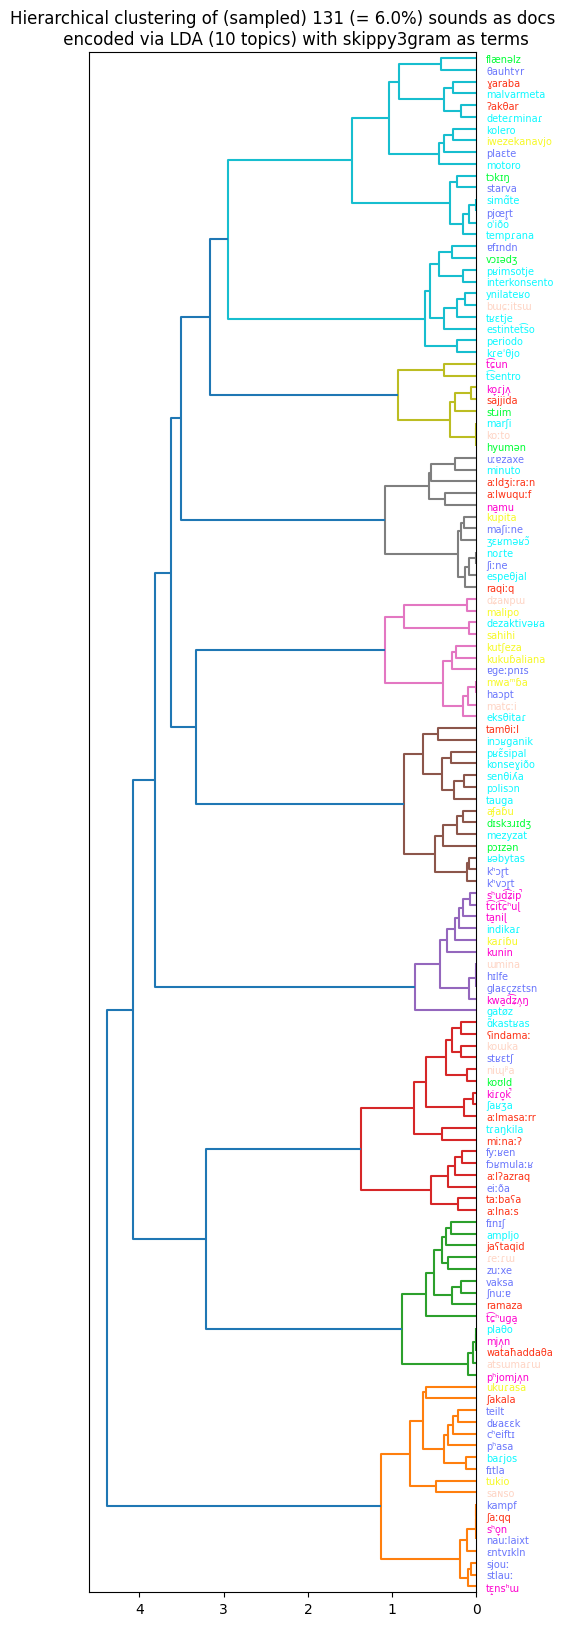

In [432]:
## doc 階層クラスタリングの実行
import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
hc_doc_enc = list(hc_df['enc'])
doc_linkage = linkage(hc_doc_enc, method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (5, round(len(hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s as docs\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = hc_df.loc[hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    #ticker.set_color(plotly.colors.qualitative.Plotly[lang_id])
    ticker.set_color(color_palette[lang_id])
#
plt.show()